## Positions plot for M. Reiss proposal 2020



In [1]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.dates import  DateFormatter
import seaborn as sns
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import numba
from numba import jit
import multiprocessing
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import astropy

import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.coordinates
from sunpy.coordinates import frames



#because script is not in root directory of package
sys.path.append('..')
import heliocats.data as hd


################################## FUNCTIONS #############################################

@jit(nopython=True)
def sphere2cart(r, phi, theta):
    x = r*np.cos(theta)*np.cos(phi)
    y = r*np.cos(theta)*np.sin(phi)
    z = r*np.sin(theta)
    return (x, y, z) 

@jit(nopython=True)
def cart2sphere(x,y,z):
    r = np.sqrt(x**2+ y**2 + z**2)            # r
    theta = np.arctan2(z,np.sqrt(x**2+ y**2))     # theta
    phi = np.arctan2(y,x)                        # phi
    return (r, theta, phi)


plt.rcParams["figure.figsize"] = (20,10)



def convert_heeq_longitude_to_carrington(time, lon):

    heeq_lon = SkyCoord(np.degrees(lon)*u.deg, np.degrees(0)*u.deg, 1*u.AU, frame="heliographic_stonyhurst",  obstime=time)
    carr_lon=heeq_lon.transform_to(frames.HeliographicCarrington)
    
    return carr_lon.lon.rad




ProxySchemeUnknown: Not supported proxy scheme None

## generate in situ data and positions

In [4]:
#https://docs.sunpy.org/en/latest/code_ref/coordinates/index.html#supported-coordinate-systems


############################################ SETTINGS


#Coordinate System
frame='HCI'
#frame='HEEQ'

print(frame)

#Time resolution
res_hours=24

print(res_hours)
start=time.time()
##########################################  PSP

starttime =datetime(2020, 1,1)
endtime = datetime(2025, 8, 31)
psp_time = []
while starttime < endtime:
    psp_time.append(starttime)
    starttime += timedelta(hours=res_hours)

spice.furnish(spicedata.get_kernel('psp_pred'))
psp=spice.Trajectory('SPP')
psp.generate_positions(psp_time,'Sun',frame)
print('PSP pos')

psp.change_units(astropy.units.AU)  
[psp_r, psp_lat, psp_lon]=cart2sphere(psp.x,psp.y,psp.z)


#to carrington longitude in radians
#psp_lon_carr=convert_heeq_longitude_to_carrington(psp_time,psp_lon)

print('PSP conv')



#################################################### Solar Orbiter

starttime = datetime(2020, 3, 1)
endtime = datetime(2025, 12, 31)
solo_time = []
while starttime < endtime:
    solo_time.append(starttime)
    starttime += timedelta(hours=res_hours)

spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(solo_time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[solo_r, solo_lat, solo_lon]=cart2sphere(solo.x,solo.y,solo.z)

#to carrington longitude in radians
#solo_lon_carr=convert_heeq_longitude_to_carrington(solo_time,solo_lon)



print('Solo conv')



planet_kernel=spicedata.get_kernel('planet_trajectories')
starttime =datetime(2020, 1, 1)
endtime = datetime(2025, 12, 31)
earth_time = []
while starttime < endtime:
    earth_time.append(starttime)
    starttime += timedelta(hours=res_hours)


earth=spice.Trajectory('399')  #399 for Earth, not barycenter (because of moon)
earth.generate_positions(earth_time,'Sun',frame)
earth.change_units(astropy.units.AU)  
[earth_r, earth_lat, earth_lon]=cart2sphere(earth.x,earth.y,earth.z)

#earth_lon_carr=convert_heeq_longitude_to_carrington(earth_time,earth_lon)

print('Earth done')


starttime =datetime(2020, 1, 1)
endtime = datetime(2025, 12, 31)
sta2_time = []
while starttime < endtime:
    sta2_time.append(starttime)
    starttime += timedelta(hours=res_hours)

spice.furnish(spicedata.get_kernel('stereo_a_pred'))
sta2=spice.Trajectory('-234')  
sta2.generate_positions(sta2_time,'Sun',frame)  
sta2.change_units(astropy.units.AU)  
[sta2_r, sta2_lat, sta2_lon]=hd.cart2sphere(sta2.x,sta2.y,sta2.z)
#sta2_lon_carr=convert_heeq_longitude_to_carrington(sta2_time,sta2_lon)


print('STEREO-A done') 




end=time.time()
print( 'generate position took time in seconds:', round((end-start),1) )




HCI
24


PSP pos
PSP conv


Solo conv
Earth done
STEREO-A done
generate position took time in seconds: 3.0


### Make plot

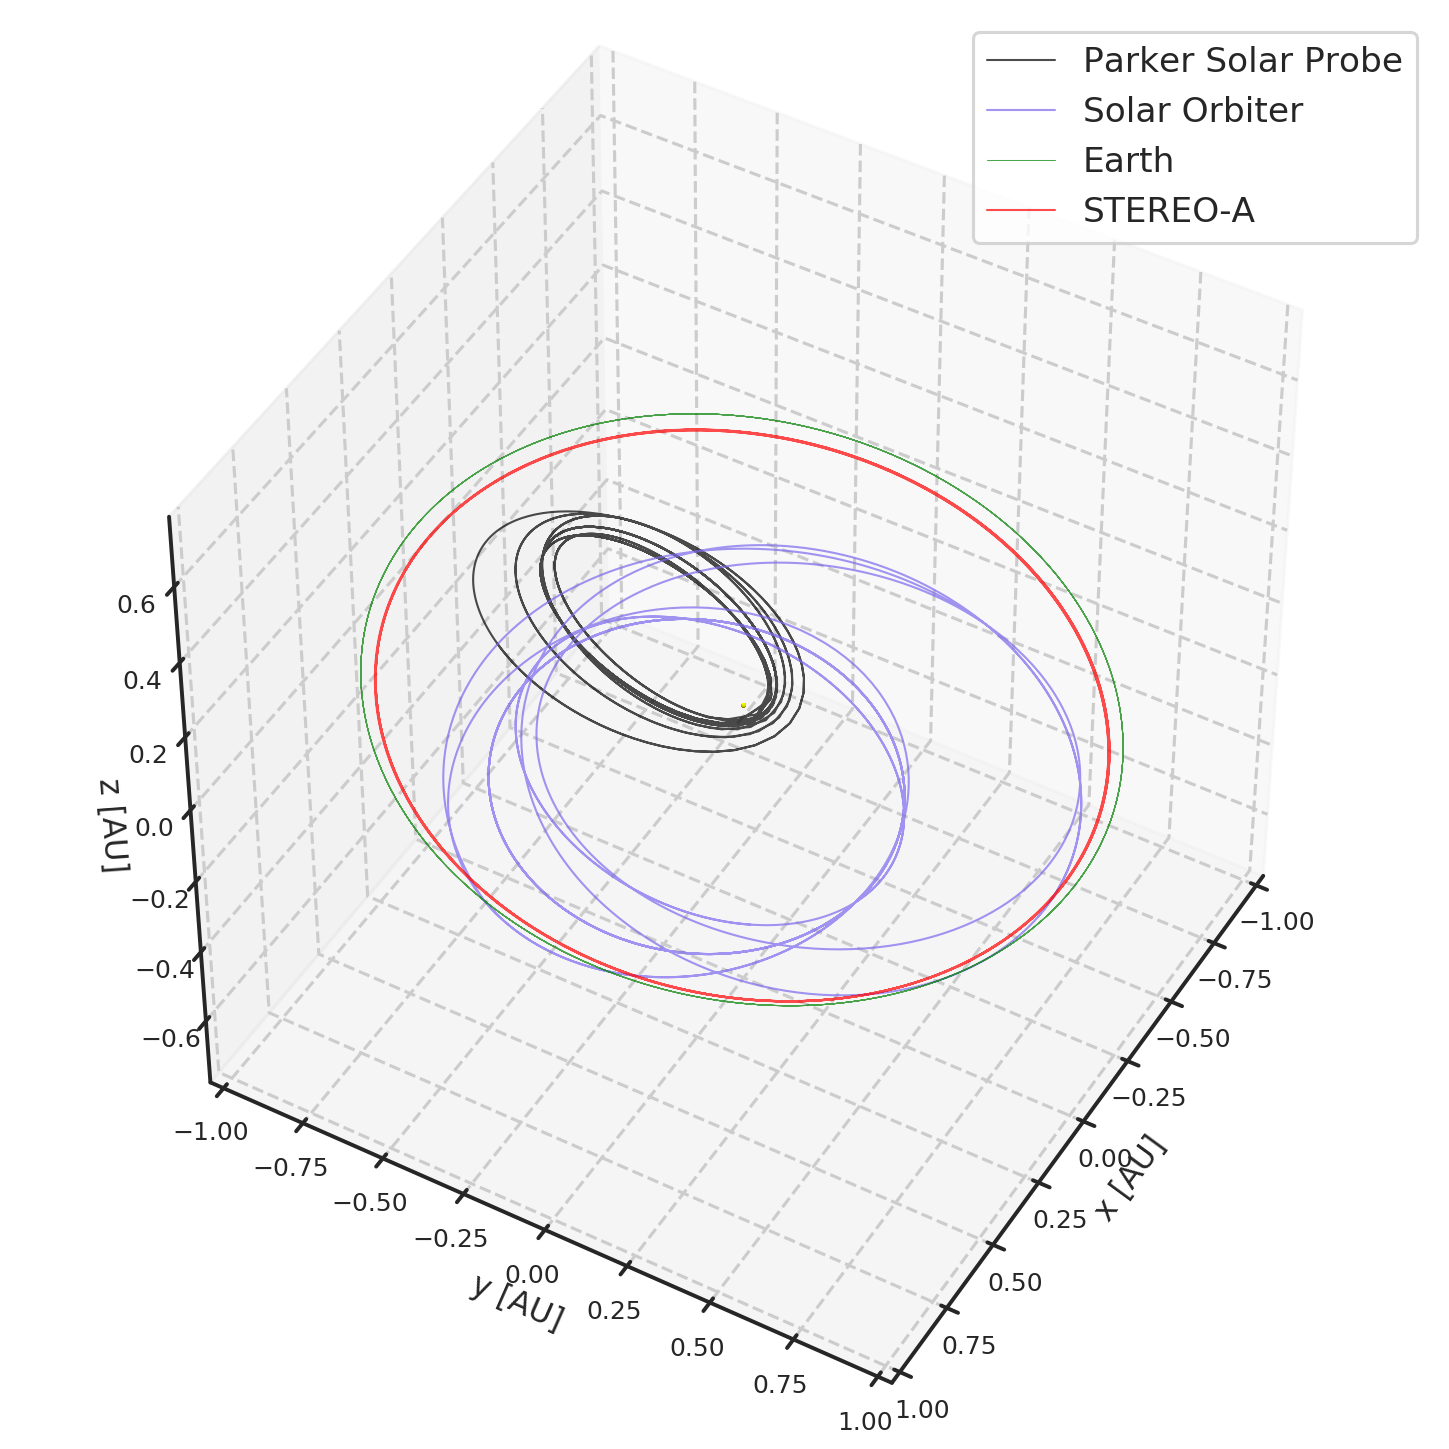

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap

sns.set_context("talk")     
#sns.set_style('darkgrid')
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})


plt.figure(1,figsize=(10, 10),dpi=150)

ax = plt.subplot2grid((1, 1), (0, 0),projection='3d') 


#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
x = np.cos(u)*np.sin(v)*scale
y = np.sin(u)*np.sin(v)*scale
z = np.cos(v)*scale



def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)
    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    #adjust scaling as matplotlib lacks automatic aspect ratio setting
    ax.set_zlim([-view_radius*0.75, view_radius*0.75])    
    
    #draw sun        
    ls = LightSource(azdeg=120, altdeg=90)  
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=False,zorder=5)
        
    #ax.set_axis_off()

plot_configure(ax, view_azim=30, view_elev=45, view_radius=1.0)



psp_color='black'
#bepi_color='coral'
solo_color='mediumslateblue'


AUkm=149597870.7   

ax.plot(psp.x, psp.y, psp.z, c=psp_color, alpha=0.7,lw=1.0,zorder=3, label='Parker Solar Probe')
ax.plot(solo.x, solo.y, solo.z, c=solo_color, alpha=0.7,lw=1.0,zorder=3,label='Solar Orbiter')
ax.plot(earth.x, earth.y, earth.z, c='green', alpha=0.7,lw=0.5,zorder=3,label='Earth')
ax.plot(sta2.x, sta2.y, sta2.z, c='red', alpha=0.7,lw=1.0,zorder=3,label='STEREO-A')

ax.legend()

ax.set_xlabel('x [AU]',fontsize=15)
ax.set_ylabel('y [AU]',fontsize=15)
ax.set_zlabel('z [AU]',fontsize=15)
#ax.set_xticklabels(fontsize=10)

ax.tick_params(axis='x', labelsize='12' )
ax.tick_params(axis='y', labelsize='12' )
ax.tick_params(axis='z', labelsize='12' )





plt.tight_layout()


plt.savefig('../results/reiss_2020/positions.png',dpi=100)
plt.savefig('../results/reiss_2020/positions.pdf')

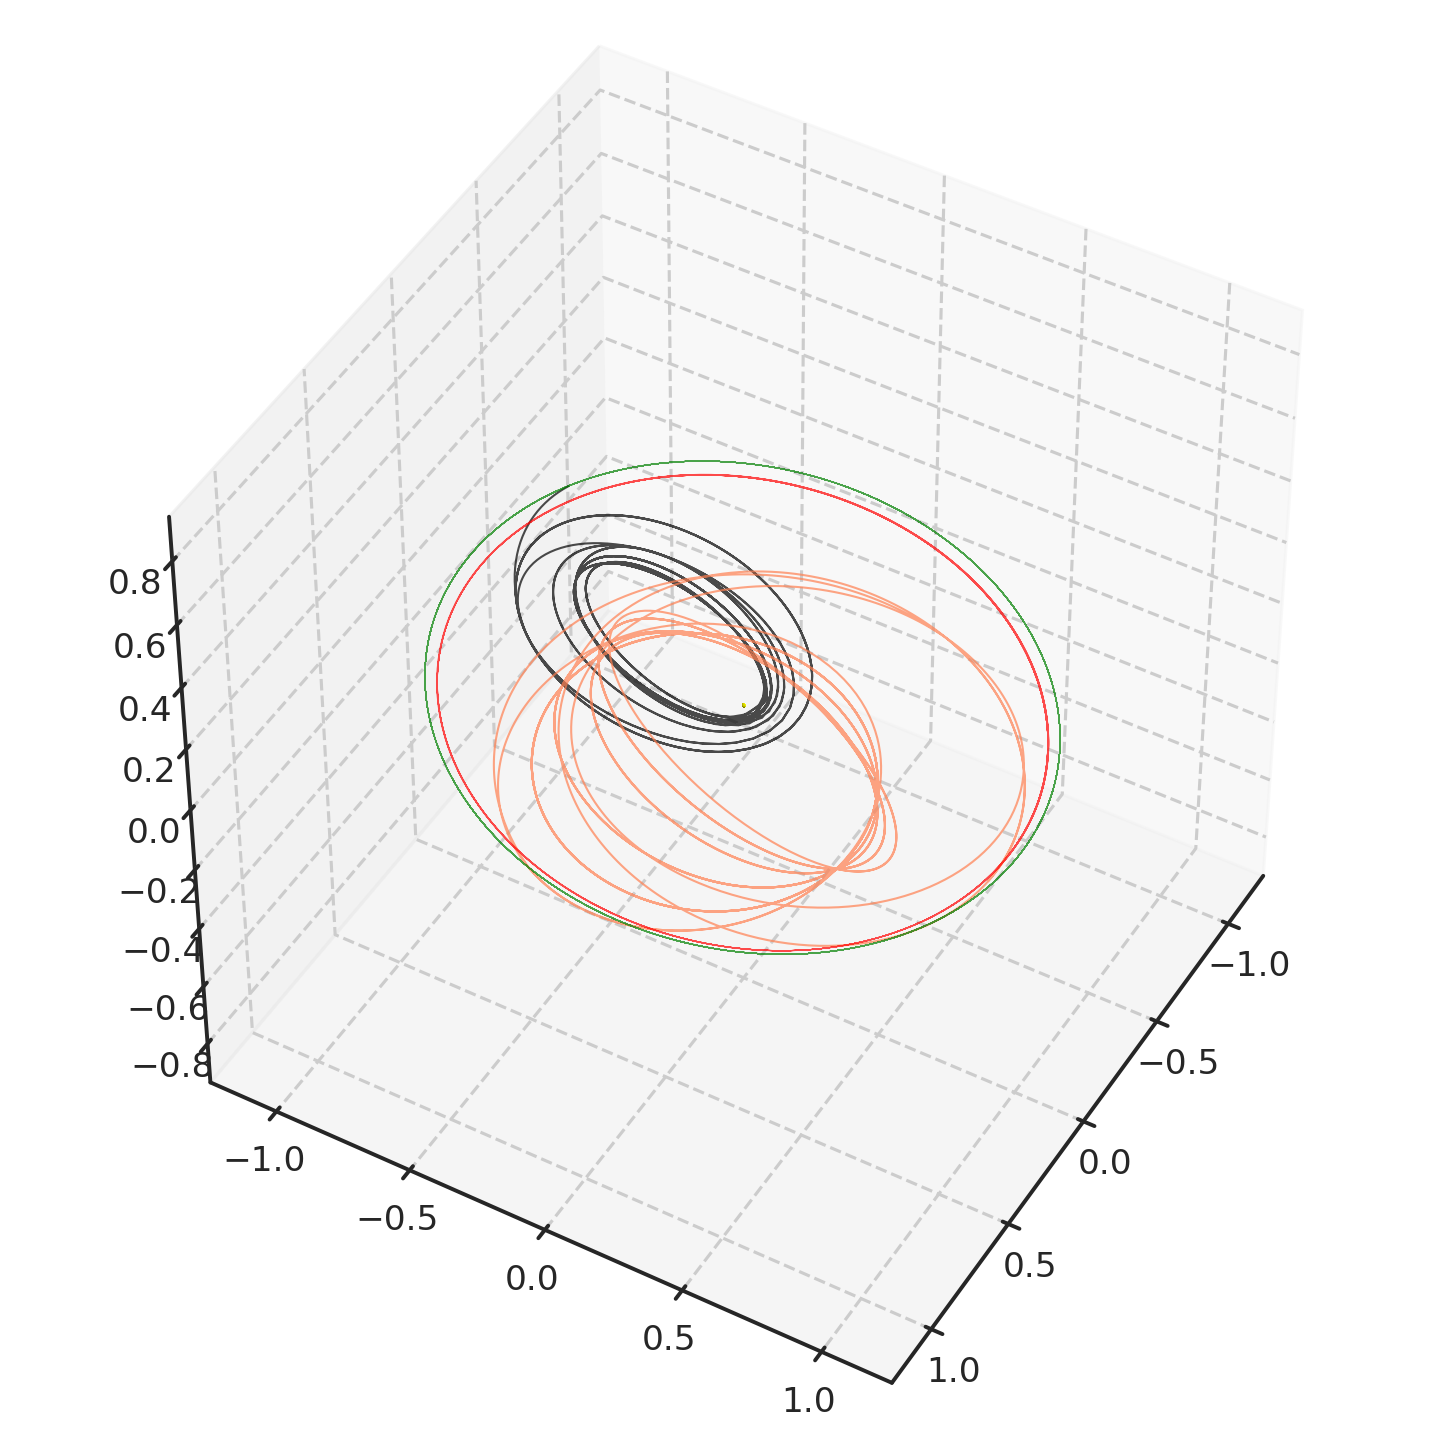

In [70]:
#ax3.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='orange', alpha=1,lw=0,zorder=3)
#ax3.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
#ax3.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
#ax3.scatter(sta.lon[earth_timeind], sta.r[earth_timeind]*np.cos(sta.lat[earth_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
#ax3.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=1,lw=0,zorder=3)

#ax3.plot(psp_lon, psp_r*np.cos(psp_lat), c=psp_color, alpha=1,lw=1,zorder=3)
#ax3.plot(sta_lon, sta_r*np.cos(sta_lat), c='red', alpha=1,lw=1,zorder=3)
#ax3.plot(earth_lon, earth_r*np.cos(earth_lat), c='mediumseagreen', alpha=1,lw=1,zorder=3)
#ax3.plot(bepi_lon, bepi_r*np.cos(bepi_lat), c=bepi_color, alpha=1,lw=1,zorder=3)
#ax3.plot(solo_lon, solo_r*np.cos(solo_lat), c='green', alpha=1,lw=1,zorder=3)


#ax3.plot(sta_lon, sta_r*np.cos(sta_lat), c='red', alpha=1,lw=1,zorder=3)
#ax3.plot(earth_lon, earth_r*np.cos(earth_lat), c='mediumseagreen', alpha=1,lw=1,zorder=3)
#ax3.plot(bepi_lon, bepi_r*np.cos(bepi_lat), c=bepi_color, alpha=1,lw=1,zorder=3)


#set axes and grid
#ax3.set_theta_zero_location('E')
#plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
#plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize+1,color=backcolor, alpha=0.9,zorder=4)

#plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
#plt.rgrids((0.2,0.4,0.6,0.8,1.0),('0.2','0.4','0.6','0.8','1.0 AU'),angle=65, fontsize=fsize+1,alpha=0.7, color=backcolor)

#ax.set_ylim(0, 1.75) #with Mars
#ax3.set_ylim(0, 1.2) 



#fadeind=60*24
#ax3.plot(psp.lon[psp_timeind-fadeind:psp_timeind+fadeind], psp.r[psp_timeind-fadeind:psp_timeind+fadeind]*np.cos(psp.lat[psp_timeind-fadeind:psp_timeind+fadeind]), c=psp_color, alpha=0.8,lw=1.5,zorder=3)
#ax3.plot(sta.lon[sta_timeind-fadeind:sta_timeind+fadeind], sta.r[sta_timeind-fadeind:sta_timeind+fadeind]*np.cos(sta.lat[sta_timeind-fadeind:sta_timeind+fadeind]), c='red', alpha=0.8,lw=1.5,zorder=3)




#spacecraft labels
#plt.annotate('Parker Solar Probe', (0.33,0.54), color=psp_color, ha='center',fontsize=fsize,verticalalignment='top',xycoords='figure fraction')
#ax3.text(bepi.lon[bepi_timeind]+0.26,bepi.r[bepi_timeind],'Bepi', color=bepi_color, ha='center',fontsize=fsize,verticalalignment='top')
#ax3.text(bepi.lon[bepi_timeind]+0.16,bepi.r[bepi_timeind],'Colombo', color=bepi_color, ha='center',fontsize=fsize,verticalalignment='top')
#ax3.text(sta.lon[sta_timeind]+0.14,sta.r[sta_timeind]-0.14,'STEREO-A', color='red', ha='center',fontsize=fsize,verticalalignment='top')
#ax3.text(earth.lon[earth_timeind]-0.05,earth.r[earth_timeind],'Earth', color='green', ha='center',fontsize=fsize,verticalalignment='top')


#time
#plt.annotate(mdates.num2date(frame_time_num).strftime("%Y %b %d  %H:%M")+' UT',(0.03,0.93),fontsize=fsize+3, ha='left',c='black',xycoords='figure fraction')
#plt.title(mdates.num2date(frame_time_num).strftime("%Y %b %d  %H:%M")+' UT',color='black',fontsize=25)


#plt.savefig('../results/reiss_2020/HCI_positions_white.png',dpi=200)
#plt.savefig('../results/reiss_2020/HCI_positions_white.pdf')